# Tabular Modeling Deep Dive

In [121]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image, display_svg, SVG
from dtreeviz.trees import *
from dtreeviz import dtreeviz

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Tabular modeling takes data in the form of a table (like a spreadsheet or CSV). The objective is to predict the value in one column based on the values in the other columns.

First, we will see how we can feed columns that contain *categories* into a model that expects numbers by using `embeddings`.

#### Categorical Embeddings

In tabular data some columns may contain `numerical` data, like "age," while others contain `string` values, like "sex." The numerical data can be directly fed to the model (with some optional preprocessing), but the other columns need to be converted to numbers. Since the values in those correspond to different categories, we often call this type of variables `categorical variables`. The first type are called `continuous variables`. `Categorical variables` also contain a number of discrete levels, such as "movie ID," for which addition and multiplication don't have meaning (even if they're stored as numbers).

 `Entity embedding` not only reduces memory usage and speeds up neural networks compared with `one-hot encoding`, but more importantly by mapping similar values close to each other in the embedding space it reveals the intrinsic properties of the `categorical variables`... It is especially useful for datasets with lots of high cardinality features, where other methods tend to `overfit`... As entity embedding defines a distance measure for categorical variables it can be used for visualizing categorical data and for data clustering.

An `Embedding layer` is exactly equivalent to placing an ordinary linear layer after every one-hot-encoded input layer. The authors used the diagram below to show this equivalence. Note that "dense layer" is a term with the same meaning as *linear layer*, and the one-hot encoding layers represent *inputs*.

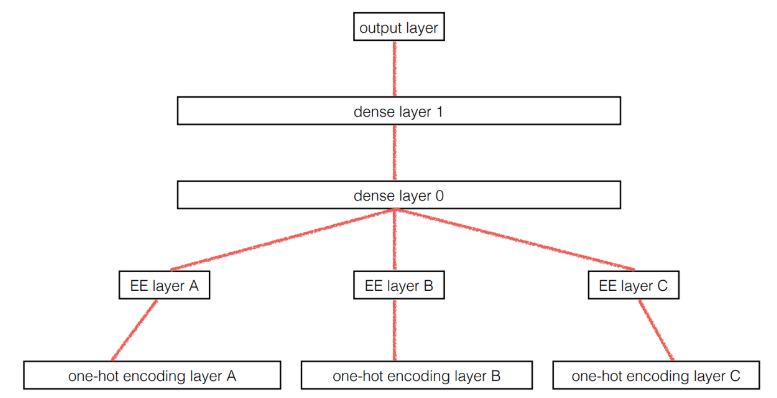

We already know how to train linear layers, so this shows that from the point of view of the architecture and our training algorithm the embedding layer is just another layer. `Embedding` transforms the `categorical variables` into inputs that are both continuous and meaningful:

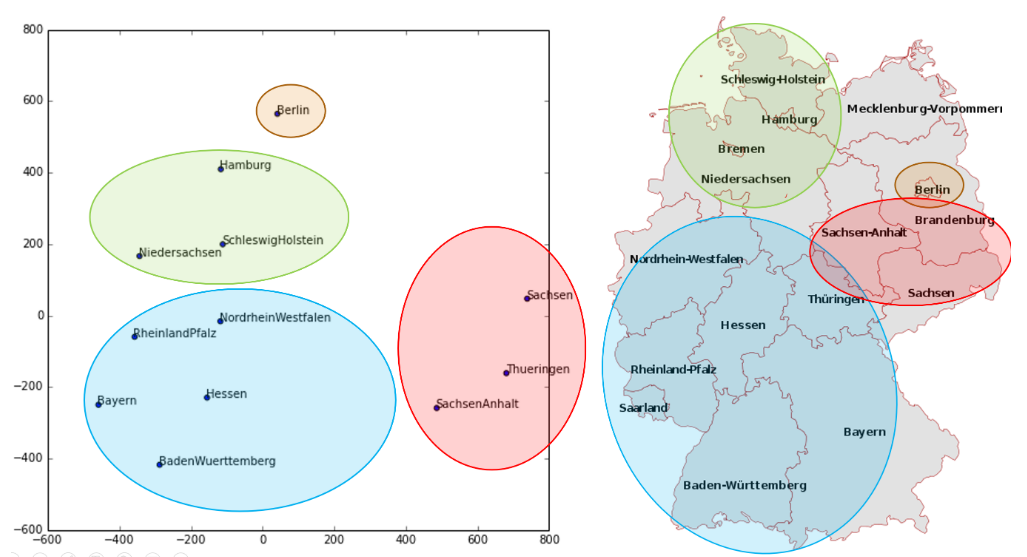

On the left is a plot of the embedding matrix for the possible values of the State category. For a categorical variable we call the possible values of the variable its "levels" (or "categories" or "classes"), so here one level is "Berlin," another is "Hamburg," etc. On the right is a map of Germany.

Do you remember how we talked about distance between embeddings? The authors of the paper plotted the distance between store embeddings against the actual geographic distance between the stores

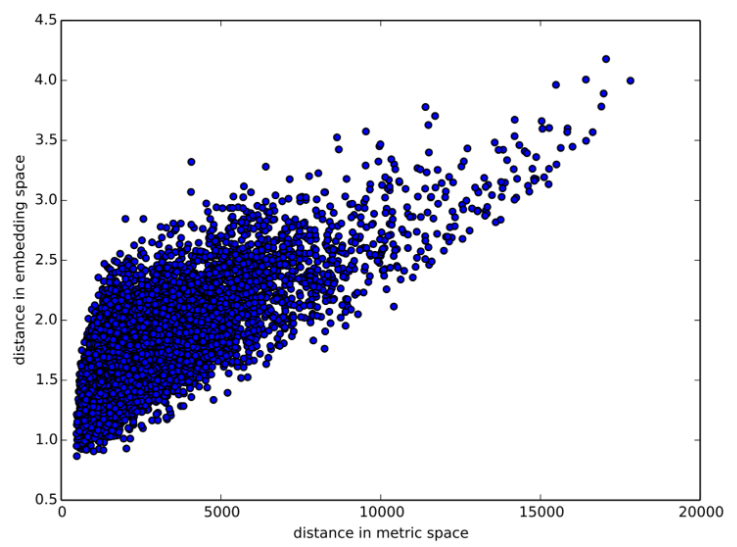

Embeddings are continuous, because models are better at understanding continuous variables. This is unsurprising considering models are built of many continuous parameter weights and continuous activation values, which are updated via gradient descent (a learning algorithm for finding the minimums of continuous functions).

Another benefit is that we can combine our continuous embedding values with truly continuous input data in a straightforward manner: we just concatenate the variables, and feed the concatenation into our first dense layer. In other words, the raw categorical data is transformed by an embedding layer before it interacts with the raw continuous input data. This is how fastai handle tabular models containing continuous and categorical variables.

An example using this concatenation approach is how Google does its recommendations on Google Play

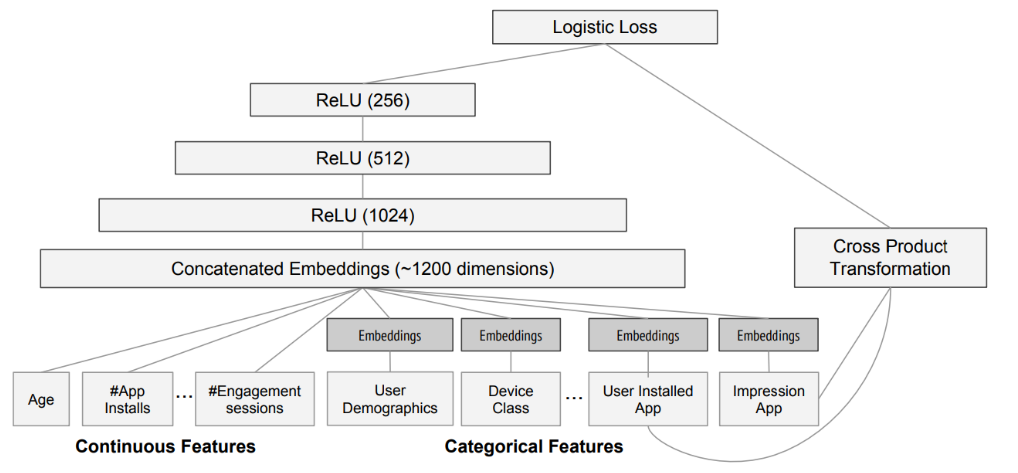

So far, the solution to all of our modeling problems has been: train a *deep learning model*. And indeed, that is a pretty good rule of thumb for complex unstructured data like images, sounds, natural language text, and so forth. Deep learning also works very well for `collaborative filtering`(recommendation system). But it is not always the best starting point for analyzing tabular data.

#### Beyond Deep Learning

Modern `machine learning` can be distilled down to a couple of key techniques that are widely applicable. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

1. Ensembles of `decision trees` (i.e., random forests and gradient boosting machines), mainly for `structured data` (such as you might find in a database table at most companies)
2. Multilayered neural networks learned with SGD (i.e., shallow and/or deep learning), mainly for `unstructured data` (such as audio, images, and natural language)

Although `deep learning` is nearly always clearly superior for unstructured data, these two approaches tend to give quite similar results for many kinds of structured data. But ensembles of decision trees tend to train faster, are often easier to interpret, do not require special GPU hardware for inference at scale, and often require less hyperparameter tuning.

Most importantly, the critical step of interpreting a model of tabular data is significantly easier for decision tree `ensembles`. Therefore, `ensembles` of decision trees are our first approach for analyzing a new tabular dataset.

The exception to this guideline is when the dataset meets one of these conditions:

1. There are some high-cardinality `categorical variables` that are very important ("cardinality" refers to the number of discrete levels representing categories, so a high-cardinality categorical variable is something like a zip code, which can take on thousands of possible levels).
2. There are some columns that contain data that would be best understood with a neural network, such as plain text data.

In practice, when we deal with datasets that meet these exceptional conditions, we always try both decision tree ensembles and deep learning to see which works best. It is likely that deep learning will be a useful approach in our example of collaborative filtering, as we have at least two high-cardinality categorical variables: the users and the movies.

Either way, it's clear that we are going to need to add *decision tree ensembles* to our modeling toolbox!

Up to now we've used PyTorch and fastai for pretty much all of our heavy lifting. But these libraries are mainly designed for algorithms that do lots of matrix multiplication and derivatives (that is, stuff like deep learning!). Decision trees don't depend on these operations at all, so PyTorch isn't much use.

Instead, we will be largely relying on a library called scikit-learn (also known as `sklearn`). Scikit-learn is a popular library for creating machine learning models, using approaches that are not covered by deep learning. In addition, we'll need to do some tabular data processing and querying, so we'll want to use the Pandas library. Finally, we'll also need NumPy, since that's the main numeric programming library that both sklearn and Pandas rely on.

First, let's gather the data we will use.

#### The Dataset

The dataset we use in this chapter is from the Blue Book for Bulldozers Kaggle competition, which has the following description: "The goal of the contest is to predict the sale price of a particular piece of heavy equipment at auction based on its usage, equipment type, and configuration. The data is sourced from auction result postings and includes information on usage and equipment configurations."

The easiest way to download Kaggle datasets is to use the Kaggle API.

In [ ]:
%pip install kaggle

In [69]:
creds = {"username":"dylanlance","key":"498d4443e7481ee2b7657974261b8f1a"}

Then execute this cell (this only needs to be run once):

In [70]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

Now you can download datasets from Kaggle! Pick a path to download the dataset to:

In [71]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
print(path)

/home/lance/.fastai/archive/bluebook-for-bulldozers


In [72]:
Path.BASE_PATH = path

And use the Kaggle API to download the dataset to that path, and extract it:

In [74]:
from kaggle import api
import shutil

if not path.exists():
    path.mkdir(parents=True)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

(#0) []

Now that we have downloaded our dataset, let's take a look at it!

#### Look at the Data

It's important to look at your data directly to make sure you understand the format, how it's stored, what types of values it holds, etc.

We'll start by reading the *training set* into a Pandas DataFrame. Generally it's a good idea to specify `low_memory=False` unless Pandas actually runs out of memory and returns an error. The `low_memory` parameter, which is `True` by default, tells Pandas to only look at a few rows of data at a time to figure out what type of data is in each column. This means that Pandas can actually end up using different data type for different rows, which generally leads to data processing errors or model training problems later.

In [76]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [77]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

At this point, a good next step is to handle *ordinal columns*. This refers to columns containing strings or similar, but where those strings have a natural ordering. For instance, here are the levels of `ProductSize`:

In [78]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

We can tell Pandas about a suitable ordering of these levels like so:

In [80]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [82]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes, ordered=True)

The most important data column is the `dependent variable`(target)—that is, the one we want to predict. Recall that a model's `metric` is a function that reflects how good the predictions are. It's important to note what metric is being used for a project. Generally, selecting the metric is an important part of the project setup. In many cases, choosing a good metric will require more than just selecting a variable that already exists. It is more like a design process. You should think carefully about which metric, or set of metrics, actually measures the notion of model quality that matters to you. If no variable represents that metric, you should see if you can build the metric from the variables that are available.

However, in this case Kaggle tells us what metric to use: `root mean squared log error (RMSLE)` between the actual and predicted auction prices. We take the log of the prices, so that rmse of that value will give us what we ultimately need:

In [83]:
dep_var = 'SalePrice'

In [84]:
df[dep_var] = np.log(df[dep_var])

#### Decision Trees

Decision tree ensembles, as the name suggests, rely on decision trees. A decision tree asks a series of binary (that is, yes or no) questions about the data. After each question the data at that part of the tree is split between a "yes" and a "no" branch, as shown in below. After one or more questions, either a prediction can be made on the basis of all previous answers or another question is required.

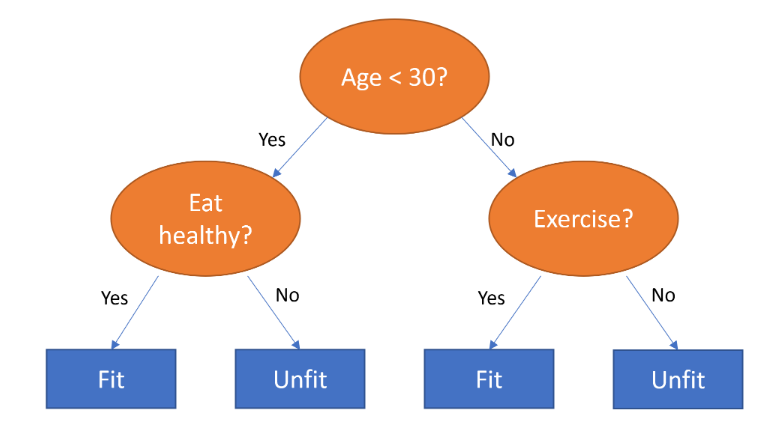

This sequence of questions is now a procedure for taking any data item, whether an item from the training set or a new one, and assigning that item to a group. Namely, after asking and answering the questions, we can say the item belongs to the same group as all the other training data items that yielded the same set of answers to the questions. But what good is this? The goal of our model is to predict values for items, not to assign them into groups from the training dataset. The value is that we can now assign a prediction value for each of these groups for `regression`, we take the target `mean` of the items in the group.

The basic steps to train a decision tree can be written down very easily:

1. Loop through each column of the dataset in turn.
2. For each column, loop through each possible level of that column in turn.
3. Try splitting the data into two groups, based on whether they are greater than or less than that value (or if it is a categorical variable, based on whether they are equal to or not equal to that level of that categorical variable).
4. Find the average sale price for each of those two groups, and see how close that is to the actual sale price of each of the items of equipment in that group. That is, treat this as a very simple "model" where our predictions are simply the average sale price of the item's group.
5. After looping through all of the columns and all the possible levels for each, pick the split point that gave the best predictions using that simple model.
6. We now have two different groups for our data, based on this selected split. Treat each of these as separate datasets, and find the best split for each by going back to step 1 for each group.
7. Continue this process recursively, until you have reached some stopping criterion for each group—for instance, stop splitting a group further when it has only 20 items in it.

Although this is an easy enough algorithm to implement yourself, we can save some time by using the implementation built into sklearn.

First, however, we need to do a little data preparation.

    A: Here's a productive question to ponder. If you consider that the procedure for defining a decision tree essentially chooses one sequence of splitting questions about variables, you might ask yourself, how do we know this procedure chooses the correct sequence? The rule is to choose the splitting question that produces the best split (i.e., that most accurately separates the items into two distinct categories), and then to apply the same rule to the groups that split produces, and so on. This is known in computer science as a "greedy" approach. Can you imagine a scenario in which asking a “less powerful” splitting question would enable a better split down the road (or should I say down the trunk!) and lead to a better result overall?

#### Handling Dates

The fundamental basis of the decision tree that we just described is `bisection` — dividing a group into two. We look at the `ordinal variables` and divide up the dataset based on whether the variable's value is greater (or lower) than a threshold, and we look at the `categorical variables` and divide up the dataset based on whether the variable's level is a particular level. So this algorithm has a way of dividing up the dataset based on both ordinal and categorical data.

You might want to treat a date as an ordinal value, because it is meaningful to say that one date is greater than another. In order to help our algorithm handle dates intelligently, we'd like our model to know more than whether a date is more recent or less recent than another. We might want our model to make decisions based on that date's day of the week, on whether a day is a holiday, on what month it is in, and so forth. To do this, we replace every date column with a set of date metadata columns, such as holiday, day of week, and month. These columns provide categorical data that we suspect will be useful.

fastai comes with a function that will do this for us—we just have to pass a column name that contains dates:

In [85]:
df = add_datepart(df, 'saledate')

/home/lance/.local/lib/python3.10/site-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


Let's do the same for the test set while we're there:

In [86]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

/home/lance/.local/lib/python3.10/site-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


We can see that there are now lots of new columns in our DataFrame:

In [87]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

This is a good first step, but we will need to do a bit more cleaning. For this, we will use fastai objects called `TabularPandas` and `TabularProc`.

#### Using TabularPandas and TabularProc

A second piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two `TabularProcs`, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

    1. It returns the exact same object that's passed to it, after modifying the object in place.
    2. It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

`Categorify` is a TabularProc that replaces a column with a *numeric categorical column*. `FillMissing` is a TabularProc that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use.

In [88]:
procs = [Categorify, FillMissing]

`TabularPandas` will also handle splitting the dataset into training and validation sets for us. However we need to be very careful about our validation set. We do want to define our validation data so that it has the same sort of relationship to the training data as the test set will have. A `validation set` is data we hold back from training in order to ensure that the training process does not overfit on the training data. A `test set` is data that is held back even more deeply, from us ourselves, in order to ensure that we don't overfit on the validation data.

In some cases, just randomly choosing a subset of your data points will do that. This is not one of those cases, because it is a time series.

If you look at the date range represented in the `test set`, you will discover that it covers a six-month period from May 2012, which is later in time than any date in the `training set`. This is a good design, because the competition sponsor will want to ensure that a model is able to predict the future. But it means that if we are going to have a useful `validation set`, we also want the validation set to be later in time than the training set. The Kaggle training data ends in April 2012, so we will define a narrower training dataset which consists only of the Kaggle training data from before November 2011, and we'll define a validation set consisting of data from after November 2011.

To do this we use `np.where`, a useful function that returns (as the first element of a tuple) the indices of all `True` values:



In [89]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

`TabularPandas` needs to be told which columns are `continuous` and which are `categorical`. We can handle that automatically using the helper function `cont_cat_split`:

In [90]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

A `TabularPandas` behaves a lot like a fastai `Datasets` object, including providing `train` and `valid` attributes:

In [92]:
len(to.train),len(to.valid)

(404710, 7988)

We can see that the data is still displayed as strings for categories (we only show a few columns here because the full table is too big to fit on a page):

In [93]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [94]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


However, the underlying items are all numeric:

In [95]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [96]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


The conversion of categorical columns to numbers is done by simply replacing each unique level with a number. The numbers associated with the levels are chosen consecutively as they are seen in a column, so there's no particular meaning to the numbers in categorical columns after conversion. The exception is if you first convert a column to a Pandas ordered category (as we did for "ProductSize" earlier), in which case the ordering you chose is used. We can see the mapping by looking at the `classes` attribute:

In [97]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

Since it takes a minute or so to process the data to get to this point, we should save it without rerunning the previous steps. fastai provides a `save` method that uses Python's pickle system to save nearly any Python object:

In [98]:
save_pickle(path/'to.pkl',to)

To read this back later, you would type:

to = (path/'to.pkl').load()

Now that all this preprocessing is done, we are ready to create a decision tree.

#### Creating the Decision Tree

To begin, we define our `independent`(input) and `dependent`(target) variables:

In [99]:
to = load_pickle(path/'to.pkl')

In [100]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

Now that our data is all numeric, and there are no missing values, we can create a decision tree:

In [101]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

To keep it simple, we've told sklearn to just create four leaf nodes. To see what it's learned, we can display the tree:

In [ ]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

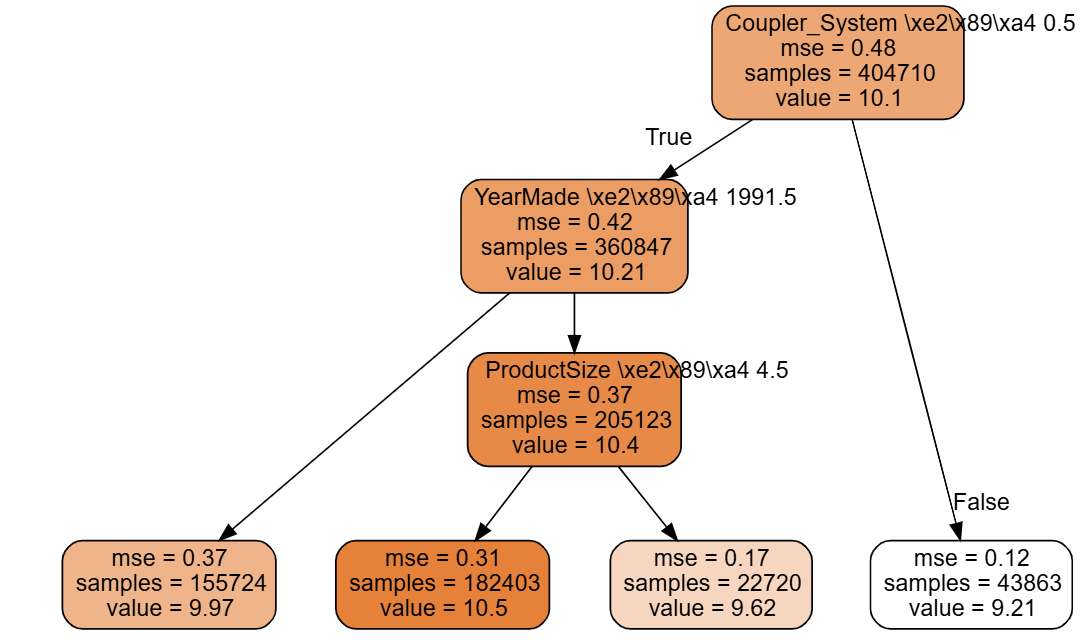

We will start at the top and explain each part step by step.

The top node represents the initial model before any splits have been done, when all the data is in one group. This is the simplest possible model. It is the result of asking zero questions and will always predict the value to be the average value of the whole dataset. In this case, we can see it predicts a value of 10.10 for the logarithm of the sales price. It gives a mean squared error of 0.48. We can also see that there are 404,710 auction records in this group—that is the total size of our training set. The final piece of information shown here is the decision criterion for the best split that was found, which is to split based on the `coupler_system` column.

Moving down and to the left, this node shows us that there were 360,847 auction records for equipment where `coupler_system` was less than 0.5. The average value of our `dependent variable` in this group is 10.21. Moving down and to the right from the initial model takes us to the records where `coupler_system` was greater than 0.5.

The bottom row contains our `leaf nodes`: the nodes with no answers coming out of them, because there are no more questions to be answered. At the far right of this row is the node containing records where `coupler_system` was greater than 0.5. The average value here is 9.21, so we can see the decision tree algorithm did find a single binary decision that separated high-value from low-value auction results. Asking only about coupler_system predicts an average value of 9.21 versus 10.1.

Returning back to the top node after the first decision point, we can see that a second binary decision split has been made, based on asking whether `YearMade` is less than or equal to 1991.5. For the group where this is true (remember, this is now following two binary decisions, based on `coupler_system` and `YearMade`) the average value is 9.97, and there are 155,724 auction records in this group. For the group of auctions where this decision is false, the average value is 10.4, and there are 205,123 records. So again, we can see that the decision tree algorithm has successfully split our more expensive auction records into two more groups which differ in value significantly.

We can show the same information using Terence Parr's powerful dtreeviz library:

In [130]:
%pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Sample a subset of the data
samp_idx = np.random.permutation(len(y))[:500]

# Create a visualization object
viz_model = model(
    m,  # Trained Decision Tree Model
    xs.iloc[samp_idx],  # Feature data
    y.iloc[samp_idx],  # Target data
    feature_names=xs.columns.tolist(),  # Column names
    target_name=dep_var,  # Target variable name
)

# Show visualization
viz_model.view()

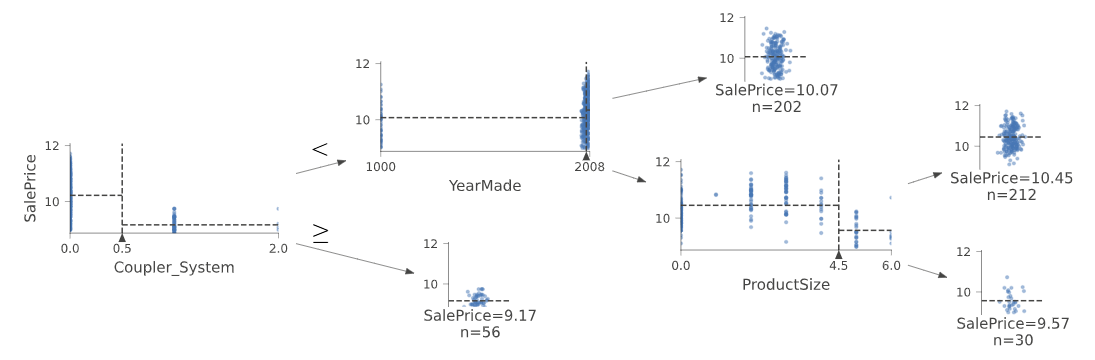

This shows a chart of the distribution of the data for each split point. We can clearly see that there's a problem with our `YearMade` data: there are bulldozers made in the year 1000, apparently! Presumably this is actually just a missing value code (a value that doesn't otherwise appear in the data and that is used as a placeholder in cases where a value is missing). For modeling purposes, 1000 is fine, but as you can see this outlier makes visualization of the values we are interested in more difficult. So, let's replace it with 1950:

In [134]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

That change makes the split much clearer in the tree visualization, even although it doesn't actually change the result of the model in any significant way. This is a great example of how resilient decision trees are to data issues!

In [135]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

We'll create a little function to check the root mean squared error of our model `(m_rmse)`, since that's how the competition was judged:

In [136]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [137]:
m_rmse(m, xs, y)

0.0

We also really need to check the `validation set`, to ensure we're not overfitting:

In [138]:
m_rmse(m, valid_xs, valid_y)

0.334947

It looks like we might be overfitting pretty badly. Here's why:

In [139]:
m.get_n_leaves(), len(xs)

(np.int64(324555), 404710)

We've got nearly as many leaf nodes as data points! That seems a little over-enthusiastic. Indeed, sklearn's default settings allow it to continue splitting nodes until there is only one item in each leaf node. Let's change the stopping rule to tell sklearn to ensure every leaf node contains at least 25 auction records:

In [140]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248595, 0.323362)

That looks much better. Let's check the number of leaves again:

In [141]:
m.get_n_leaves()

np.int64(12397)

Much more reasonable

Building a decision tree is a good way to create a model of our data. It is very flexible, since it can clearly handle nonlinear relationships and interactions between variables. But we can see there is a fundamental compromise between how well it generalizes (which we can achieve by creating small trees) and how accurate it is on the training set (which we can achieve by using large trees).

So how do we get the best of both worlds? We'll show you right after we handle an important missing detail: how to handle categorical variables.

#### Categorical Variables

In the previous chapter, when working with deep learning networks, we dealt with categorical variables by one-hot encoding them and feeding them to an embedding layer. The embedding layer helped the model to discover the meaning of the different levels of these variables (the levels of a categorical variable do not have an intrinsic meaning, unless we manually specify an ordering using Pandas). In a decision tree, we don't have embeddings layers—so how can these untreated categorical variables do anything useful in a decision tree? For instance, how could something like a product code be used?

The short answer is: it just works! Think about a situation where there is one product code that is far more expensive at auction than any other one. In that case, any binary split will result in that one product code being in some group, and that group will be more expensive than the other group. Therefore, our simple decision tree building algorithm will choose that split. Later during training the algorithm will be able to further split the subgroup that contains the expensive product code, and over time, the tree will home in on that one expensive product.

It is also possible to use one-hot encoding to replace a single categorical variable with multiple one-hot-encoded columns, where each column represents a possible level of the variable. Pandas has a `get_dummies` method which does just that. However, there is not really any evidence that such an approach improves the end result. So, we generally avoid it where possible, because it does end up making your dataset harder to work with.

It's time for the best-of-both-worlds solution: random forests.

#### Random Forests

`Bagging predictors` is a method for generating multiple versions of a predictor and using these to get an aggregated predictor. The aggregation averages over the versions... The multiple versions are formed by making bootstrap replicates of the learning set and using these as new learning sets. Tests… show that bagging can give substantial gains in accuracy. The vital element is the instability of the prediction method. If perturbing the learning set can cause significant changes in the predictor constructed, then bagging can improve accuracy.

Here is the procedure that Breiman is proposing:

    1. Randomly choose a subset of the rows of your data (i.e., "bootstrap replicates of your learning set").
    2. Train a model using this subset.
    3. Save that model, and then return to step 1 a few times.
    4. This will give you a number of trained models. To make a prediction, predict using all of the models, and then take the average of each of those model's predictions.

This procedure is known as `bagging`. It is based on a deep and important insight: although each of the models trained on a subset of data will make more errors than a model trained on the full dataset, those errors will not be correlated with each other. Different models will make different errors. The average of those errors, therefore, is: zero! So if we take the average of all of the models' predictions, then we should end up with a prediction that gets closer and closer to the correct answer, the more models we have. This is an extraordinary result—it means that we can improve the accuracy of nearly any kind of machine learning algorithm by training it multiple times, each time on a different random subset of the data, and averaging its predictions.

It demonstrated that this approach to building models, when applied to decision tree building algorithms, was particularly powerful. He went even further than just randomly choosing rows for each model's training, but also randomly selected from a subset of columns when choosing each split in each decision tree. He called this method the `random forest`. Today it is, perhaps, the most widely used and practically important machine learning method.

In essence a `random forest` is a model that averages the predictions of a large number of decision trees, which are generated by randomly varying various parameters that specify what data is used to train the tree and other tree parameters. `Bagging` is a particular approach to "ensembling," or combining the results of multiple models together. To see how it works in practice, let's get started on creating our own random forest!

#### Creating a Random Forest

We can create a random forest just like we created a decision tree, except now, we are also specifying parameters that indicate how many trees should be in the forest, how we should subset the `data items` (the rows), and how we should subset the `fields` (the columns).

In the following function definition `n_estimators` defines the number of trees we want, `max_samples` defines how many rows to sample for training each tree, and `max_features` defines how many columns to sample at each split point (where 0.5 means "take half the total number of columns"). We can also specify when to stop splitting the tree nodes, effectively limiting the depth of the tree, by including the same `min_samples_leaf` parameter we used in the last section. Finally, we pass `n_jobs=-1` to tell sklearn to use all our CPUs to build the trees in parallel. By creating a little function for this, we can more quickly try different variations in the rest of this chapter:

In [142]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [143]:
m = rf(xs, y)

Our validation RMSE is now much improved over our last result produced by the `DecisionTreeRegressor`, which made just one tree using all the available data:

In [144]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171239, 0.23328)

One of the most important properties of random forests is that they aren't very sensitive to the hyperparameter choices, such as `max_features`. You can set `n_estimators` to as high a number as you have time to train—the more trees you have, the more accurate the model will be. `max_samples` can often be left at its default, unless you have over 200,000 data points, in which case setting it to 200,000 will make it train faster with little impact on accuracy. `max_features=0.5` and `min_samples_leaf=4` both tend to work well, although sklearn's defaults work well too.

The sklearn docs show an example of the effects of different `max_features` choices, with increasing numbers of trees. In the plot, the blue plot line uses the fewest features and the green line uses the most (it uses all the features). As you can see in max_features, the models with the lowest error result from using a subset of features but with a larger number of trees.

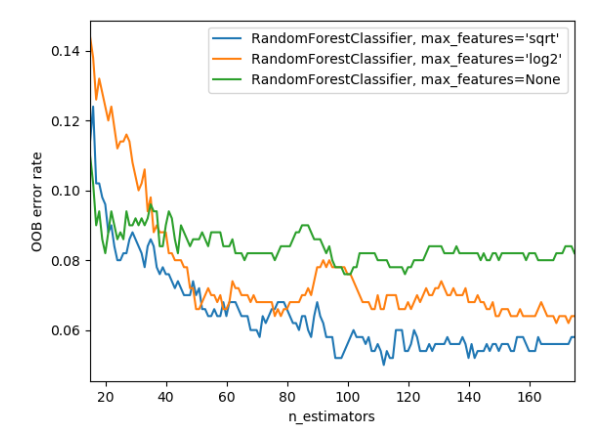

To see the impact of `n_estimators`, let's get the predictions from each individual tree in our forest (these are in the `estimators_` attribute):

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

As you can see, `preds.mean(0)` gives the same results as our random forest:

In [146]:
r_mse(preds.mean(0), valid_y)

0.23328

Let's see what happens to the RMSE as we add more and more trees. As you can see, the improvement levels off quite a bit after around 30 trees:

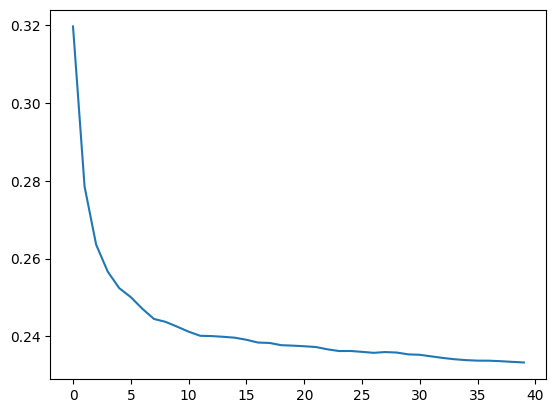

In [147]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)])

The performance on our validation set is worse than on our training set. But is that because we're overfitting, or because the validation set covers a different time period, or a bit of both? With the existing information we've seen, we can't tell. However, random forests have a very clever trick called `out-of-bag (OOB) error` that can help us with this (and more!).

#### Out-of-Bag Error

Recall that in a random forest, each tree is trained on a different subset of the training data. The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was not included in training. This allows us to see whether the model is overfitting, without needing a separate validation set.

    A: My intuition for this is that, since every tree was trained with a different randomly selected subset of rows, out-of-bag error is a little like imagining that every tree therefore also has its own validation set. That validation set is simply the rows that were not selected for that tree's training.

This is particularly beneficial in cases where we have only a small amount of training data, as it allows us to see whether our model generalizes without removing items to create a validation set. The OOB predictions are available in the `oob_prediction_` attribute. Note that we compare them to the training labels, since this is being calculated on trees using the training set.

In [148]:
r_mse(m.oob_prediction_, y)

0.21114

We can see that our OOB error is much lower than our validation set error. This means that something else is causing that error, in addition to normal generalization error. We'll discuss the reasons for this later in this chapter.

This is one way to interpret our model's predictions—let's focus on more of those now.